In [1]:
from pylab import *
%matplotlib inline

In [2]:
import numpy as np
import random

In [3]:
import data

/home/alex/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
df_nodes = data.luna16_get_df_nodes() 

In [5]:
df_nodes = df_nodes[(df_nodes["diameter_mm"]>6)]

In [6]:
patient_ids = data.luna16_get_patient_ids()

In [7]:
vsize = np.asarray([32,32,32])

In [8]:
def get_all_nodules():
    X = []
    diams = []
    for idx in range(len(df_nodes)):
        #print(idx)
        pid = df_nodes.iloc[idx]["pid"]
        image = data.luna16_get_image(pid)
        segmented_image = data.luna16_get_segmented_image(pid)
        info = data.luna16_get_info(pid)
        volume = data.luna16_get_node_volume(image, vsize, info, df_nodes, idx)
        X.append(volume.copy())
        diams.append(df_nodes.iloc[idx]["diameter_mm"])
    return X, diams

In [9]:
X_nodules, diams = get_all_nodules()

In [10]:
import scipy.ndimage.filters

In [11]:
def compose_make_mask(vsize, diam, sigma):
    grid = np.indices(vsize).astype(np.float32)
    grid = grid - vsize[:,None,None,None]/2.0
    mask = np.sqrt(np.sum(np.square(grid), axis=0)) < diam/2
                    
    mask = scipy.ndimage.filters.gaussian_filter(mask.astype(np.float32), sigma=sigma)
    return mask


In [12]:
def make_augmented(volume):
    idx = random.choice(range(len(X_nodules)))
    nodule = X_nodules[idx]
    # randomly flip or not flip each axis
    if random.choice([True, False]):
        nodule = nodule[::-1,:,:]
    if random.choice([True, False]):
        nodule = nodule[:,::-1,:]
    if random.choice([True, False]):
        nodule = nodule[:,:,::-1]
    mask = compose_make_mask(vsize, diam=diams[idx]+6, sigma=(diams[idx]+6)/8)
    volume_aug = data.compose_max2(volume, nodule, mask)
    return volume_aug

In [13]:
X_backgrounds_lung = []
X_backgrounds_tissue = []
X_backgrounds_any = []
X_augmented_nodules = []

central_mask = compose_make_mask(vsize, diam=6+6, sigma=(6+6)/8)

n = 0
while True:
    if n % 10 == 0:
        try:
            pid = random.choice(patient_ids)
            image_ = data.luna16_get_image(pid)
            segmented_image_ = data.luna16_get_segmented_image(pid)
            
            image, segmented_image = image_, segmented_image_
            # info = data.luna16_get_info(pid)
        except Exception as e:
            print(pid, repr(e))
            continue

    n+=1
            
    pos = np.asarray([ np.random.randint(k, image.shape[k] - vsize[k]) for k in range(3) ])
    volume = image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
    segmented_volume = segmented_image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
    overlap = np.mean(segmented_volume)
    density = np.mean(volume)
    central_density = np.sum(np.mean((volume+1000) * central_mask)) / np.sum(central_mask) - 1000
    
    #print(overlap, density, central_density)
    
    if len(X_backgrounds_any) < 5000:
        X_backgrounds_any.append(volume.copy())
        continue
        
    if density > -320 and len(X_backgrounds_tissue) < 5000:
        X_backgrounds_tissue.append(volume.copy())
        continue
        
    if overlap > 0 and central_density < -320 and len(X_augmented_nodules) < 10000:
        try:
            volume_aug = make_augmented(volume)
            X_augmented_nodules.append(volume_aug.copy())
            X_backgrounds_lung.append(volume.copy())
        except Exception as e:
            print(pid, repr(e))
            continue
        
    if len(X_backgrounds_any) >= 5000 and \
        len(X_backgrounds_tissue) >= 5000 and \
        len(X_backgrounds_lung) >= 10000 and \
        len(X_augmented_nodules) >= 10000:
        break

1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314 ValueError('mmap length is greater than file size',)
1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197 ValueError('mmap length is greater than file size',)
1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951 ValueError('mmap length is greater than file size',)
1.3.6.1.4.1.14519.5.2.1.6279.6001.101228986346984399347858840086 ValueError('mmap length is greater than file size',)
1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813 ValueError('mmap length is greater than file size',)
1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562 ValueError('mmap length is greater than file size',)
1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509 ValueError('mmap length is greater than file size',)
1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210 ValueError('mmap length is greater than file size',)
1.3.6.1.4.1.14519.5.2.1.6279.6001.2202053007148524834832

In [15]:
len(X_backgrounds_any)

100

In [14]:
X = np.stack(X_backgrounds_lung + X_backgrounds_tissue + X_backgrounds_any + X_augmented_nodules).astype(np.int16)

In [15]:
np.save("/mnt/data/luna16/sets/toy_set_v2_30k.npy", X[:,:,:,:,None])

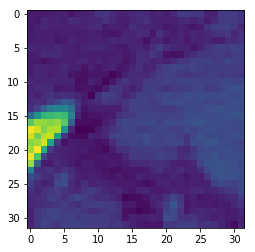

In [57]:
imshow(X_backgrounds_tissue[10][16])